# Cal-CRAI Index: Climate Domain

**Order of operations**:
- Metric handling
   - Retrieve data
   - Min-max standardization
   - Set vulnerability orientation (pos for vulnerable, neg for resilience)
- Calculate indicators
   - Calculate products for non weighted and weighted climate risk scenarios
   - Min-max standardization
- Calculate domain score
- Visualizations

Note: Functions and figures within this notebook are in development

In [2]:
import pandas as pd
import os
import sys
import warnings
import numpy as np

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import plot_domain, plot_region_domain
from scripts.utils.calculate_index import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats, compute_summed_climate_indicators)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [3]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


## Create a new folder for pulled climate data
* last columns from each climate metric file are isolated
* set island tract data to NaN
* merge all metric columns together based on GEOID

In [5]:
# domain-specific
domain_prefix = 'climate_'
input_folder = r'aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'../utils/calcrai_metrics.csv'
#meta_csv = r'C:/Users/jespi/eagle/carb-climate-index-2/scripts/utils/calcrai_metrics.csv'
merged_output_file = f'concatenate_{domain_prefix}metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 33 CSV files within climate_domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_climate_metrics.csv


### Now, take a look at the merged singluar csv file

In [6]:
# read-in and view processed data
pd.set_option('display.max_columns', None)
cleaned_climate_df = pd.read_csv(merged_output_file)
cleaned_climate_df

,GEOID,drought_coverage_percentage,drought_crop_loss_acres,drought_crop_loss_indemnity_amount,change_in_drought_years,percent_weeks_drought,mean_change_annual_heat_days,mean_change_annual_warm_nights,floodplain_percentage,avg_flood_insurance_payout_per_claim,estimated_flood_crop_loss_cost,precip_99percentile,surface_runoff,total_flood_fatalities,median_flood_warning_days,mean_change_cold_days,heat_crop_loss_acres,heat_crop_loss_indemnity_amount,avg_age_adjust_heat_hospitalizations_per_10000,median_heat_warning_days,slr_vulnerable_building_content_cost,fire_stations_count_diff,hospitals_count_diff,police_stations_count_diff,schools_count_diff,building_exposed_slr_count,slr_vulnerability_delta_percentage_change,slr_vulnerable_wastewater_treatment_count,rcp_4.5__50th_percent_change,burn_area_m2,change_ffwi_days,average_damaged_destroyed_structures_wildfire,average_annual_fatalities_wildfire,median_red_flag_warning_days
0,6001400100,37.984370,197.583333,7394.25,3.500000,0.570255,2.683333,17.908333,NaN,5463.8925,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,2.0,650084.0,3.0,0.0,1.0,14.0,1315.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,3.5
1,6001400200,37.984370,197.583333,7394.25,3.500000,0.570255,2.766667,18.758333,NaN,NaN,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,1.0,434115.0,3.0,0.0,1.0,14.0,775.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
2,6001400300,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2600.0000,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,922941.0,3.0,0.0,1.0,14.0,1941.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
3,6001400400,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,NaN,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,594158.0,3.0,0.0,1.0,14.0,1328.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
4,6001400500,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2625.3700,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,398157.0,3.0,0.0,1.0,14.0,1057.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,38.971624,NaN,NaN,10.000000,0.571168,9.284259,10.201852,0.02,NaN,0.0,0.649380,0.018775,3.0,1.0,-3.433333,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-38172.890,-1.183333,22.0,0.0,4.0
9125,6115041001,38.971624,NaN,NaN,10.750000,0.571168,8.808889,9.591389,45.42,NaN,0.0,0.547662,0.082888,3.0,2.0,-3.268750,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-51149.184,-1.777083,22.0,0.0,4.0
9126,6115041002,38.971624,NaN,NaN,10.125000,0.571168,9.257895,9.825877,5.96,NaN,0.0,1.119589,0.337733,3.0,2.0,-3.354167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10727.109,-1.762500,22.0,0.0,5.5
9127,6115041101,38.971624,NaN,NaN,8.333333,0.571168,9.950170,10.663265,0.33,NaN,0.0,2.578545,1.122988,3.0,4.0,-2.929167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,966470.400,-0.556944,22.0,0.0,8.5


# Handle sea level rise data metrics

### Step 1) Pull sea level mask data from utils folder and merge with climate dataframe

In [23]:
slr_mask_data = r'../utils/slr_mask_layer.csv'
#slr_mask_data = r'C:/Users/jespi/eagle/carb-climate-index-2/scripts/utils/slr_mask_layer.csv'
slr_mask = pd.read_csv(slr_mask_data)
slr_mask = slr_mask.drop(columns={'county', 'geometry', 'COUNTYFP'})

In [24]:
processed_climate_df = pd.merge(cleaned_climate_df, slr_mask, on='GEOID', how='left')
processed_climate_df

,GEOID,drought_coverage_percentage,drought_crop_loss_acres,drought_crop_loss_indemnity_amount,change_in_drought_years,percent_weeks_drought,mean_change_annual_heat_days,mean_change_annual_warm_nights,floodplain_percentage,avg_flood_insurance_payout_per_claim,estimated_flood_crop_loss_cost,precip_99percentile,surface_runoff,total_flood_fatalities,median_flood_warning_days,mean_change_cold_days,heat_crop_loss_acres,heat_crop_loss_indemnity_amount,avg_age_adjust_heat_hospitalizations_per_10000,median_heat_warning_days,slr_vulnerable_building_content_cost,fire_stations_count_diff,hospitals_count_diff,police_stations_count_diff,schools_count_diff,building_exposed_slr_count,slr_vulnerability_delta_percentage_change,slr_vulnerable_wastewater_treatment_count,rcp_4.5__50th_percent_change,burn_area_m2,change_ffwi_days,average_damaged_destroyed_structures_wildfire,average_annual_fatalities_wildfire,median_red_flag_warning_days,slr_impacted
0,6001400100,37.984370,197.583333,7394.25,3.500000,0.570255,2.683333,17.908333,NaN,5463.8925,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,2.0,650084.0,3.0,0.0,1.0,14.0,1315.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,3.5,1
1,6001400200,37.984370,197.583333,7394.25,3.500000,0.570255,2.766667,18.758333,NaN,NaN,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,1.0,434115.0,3.0,0.0,1.0,14.0,775.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0,1
2,6001400300,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2600.0000,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,922941.0,3.0,0.0,1.0,14.0,1941.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0,1
3,6001400400,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,NaN,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,594158.0,3.0,0.0,1.0,14.0,1328.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0,1
4,6001400500,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2625.3700,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,398157.0,3.0,0.0,1.0,14.0,1057.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,38.971624,NaN,NaN,10.000000,0.571168,9.284259,10.201852,0.02,NaN,0.0,0.649380,0.018775,3.0,1.0,-3.433333,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-38172.890,-1.183333,22.0,0.0,4.0,0
9125,6115041001,38.971624,NaN,NaN,10.750000,0.571168,8.808889,9.591389,45.42,NaN,0.0,0.547662,0.082888,3.0,2.0,-3.268750,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-51149.184,-1.777083,22.0,0.0,4.0,0
9126,6115041002,38.971624,NaN,NaN,10.125000,0.571168,9.257895,9.825877,5.96,NaN,0.0,1.119589,0.337733,3.0,2.0,-3.354167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10727.109,-1.762500,22.0,0.0,5.5,0
9127,6115041101,38.971624,NaN,NaN,8.333333,0.571168,9.950170,10.663265,0.33,NaN,0.0,2.578545,1.122988,3.0,4.0,-2.929167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,966470.400,-0.556944,22.0,0.0,8.5,0


### Step 2) Create a dictionary that houses all slr metric columns

* point to slr_impacted and set any SLR column to NaN if slr_impacted is equal to 0 (inland tract not impacted by SLR)

In [25]:
sea_level_rise_dict={
    'sea_level_rise': [
        'slr_vulnerable_building_content_cost',
        'building_exposed_slr_count',
        'slr_vulnerability_delta_percentage_change',
        'slr_vulnerable_wastewater_treatment_count',
        'rcp_4.5__50th_percent_change',
        'fire_stations_count_diff',
        'hospitals_count_diff',
        'police_stations_count_diff',
        'schools_count_diff']
}

sea_level_rise_columns = sea_level_rise_dict['sea_level_rise']

available_slr_columns = [col for col in sea_level_rise_columns if col in processed_climate_df.columns]

# Assign NaN to the selected columns where 'slr_impacted' is 0
processed_climate_df.loc[processed_climate_df['slr_impacted'] == 0, available_slr_columns] = np.nan


In [26]:
# then drop the slr_impacted column as we no longer need it
processed_climate_df = processed_climate_df.drop(columns={'slr_impacted'})

In [27]:
processed_climate_df

,GEOID,drought_coverage_percentage,drought_crop_loss_acres,drought_crop_loss_indemnity_amount,change_in_drought_years,percent_weeks_drought,mean_change_annual_heat_days,mean_change_annual_warm_nights,floodplain_percentage,avg_flood_insurance_payout_per_claim,estimated_flood_crop_loss_cost,precip_99percentile,surface_runoff,total_flood_fatalities,median_flood_warning_days,mean_change_cold_days,heat_crop_loss_acres,heat_crop_loss_indemnity_amount,avg_age_adjust_heat_hospitalizations_per_10000,median_heat_warning_days,slr_vulnerable_building_content_cost,fire_stations_count_diff,hospitals_count_diff,police_stations_count_diff,schools_count_diff,building_exposed_slr_count,slr_vulnerability_delta_percentage_change,slr_vulnerable_wastewater_treatment_count,rcp_4.5__50th_percent_change,burn_area_m2,change_ffwi_days,average_damaged_destroyed_structures_wildfire,average_annual_fatalities_wildfire,median_red_flag_warning_days
0,6001400100,37.984370,197.583333,7394.25,3.500000,0.570255,2.683333,17.908333,NaN,5463.8925,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,2.0,650084.0,3.0,0.0,1.0,14.0,1315.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,3.5
1,6001400200,37.984370,197.583333,7394.25,3.500000,0.570255,2.766667,18.758333,NaN,NaN,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,1.0,434115.0,3.0,0.0,1.0,14.0,775.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
2,6001400300,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2600.0000,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,922941.0,3.0,0.0,1.0,14.0,1941.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
3,6001400400,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,NaN,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,594158.0,3.0,0.0,1.0,14.0,1328.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
4,6001400500,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2625.3700,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,398157.0,3.0,0.0,1.0,14.0,1057.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,38.971624,NaN,NaN,10.000000,0.571168,9.284259,10.201852,0.02,NaN,0.0,0.649380,0.018775,3.0,1.0,-3.433333,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-38172.890,-1.183333,22.0,0.0,4.0
9125,6115041001,38.971624,NaN,NaN,10.750000,0.571168,8.808889,9.591389,45.42,NaN,0.0,0.547662,0.082888,3.0,2.0,-3.268750,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-51149.184,-1.777083,22.0,0.0,4.0
9126,6115041002,38.971624,NaN,NaN,10.125000,0.571168,9.257895,9.825877,5.96,NaN,0.0,1.119589,0.337733,3.0,2.0,-3.354167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10727.109,-1.762500,22.0,0.0,5.5
9127,6115041101,38.971624,NaN,NaN,8.333333,0.571168,9.950170,10.663265,0.33,NaN,0.0,2.578545,1.122988,3.0,4.0,-2.929167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,966470.400,-0.556944,22.0,0.0,8.5


### Vulnerability Orientation

All climate domain metrics are vulnerable, so we do not need to worry about the metric_vulnerable_resilient_dict dictionary or rebasing values as we do in all other domains

### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [28]:
# standardizing our df
columns_to_process = [col for col in processed_climate_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(processed_climate_df, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [29]:
min_max_metrics

,GEOID,drought_coverage_percentage_min,drought_coverage_percentage_max,drought_coverage_percentage_min_max_standardized,drought_crop_loss_acres_min,drought_crop_loss_acres_max,drought_crop_loss_acres_min_max_standardized,drought_crop_loss_indemnity_amount_min,drought_crop_loss_indemnity_amount_max,drought_crop_loss_indemnity_amount_min_max_standardized,change_in_drought_years_min,change_in_drought_years_max,change_in_drought_years_min_max_standardized,percent_weeks_drought_min,percent_weeks_drought_max,percent_weeks_drought_min_max_standardized,mean_change_annual_heat_days_min,mean_change_annual_heat_days_max,mean_change_annual_heat_days_min_max_standardized,mean_change_annual_warm_nights_min,mean_change_annual_warm_nights_max,mean_change_annual_warm_nights_min_max_standardized,floodplain_percentage_min,floodplain_percentage_max,floodplain_percentage_min_max_standardized,avg_flood_insurance_payout_per_claim_min,avg_flood_insurance_payout_per_claim_max,avg_flood_insurance_payout_per_claim_min_max_standardized,estimated_flood_crop_loss_cost_min,estimated_flood_crop_loss_cost_max,estimated_flood_crop_loss_cost_min_max_standardized,precip_99percentile_min,precip_99percentile_max,precip_99percentile_min_max_standardized,surface_runoff_min,surface_runoff_max,surface_runoff_min_max_standardized,total_flood_fatalities_min,total_flood_fatalities_max,total_flood_fatalities_min_max_standardized,median_flood_warning_days_min,median_flood_warning_days_max,median_flood_warning_days_min_max_standardized,mean_change_cold_days_min,mean_change_cold_days_max,mean_change_cold_days_min_max_standardized,heat_crop_loss_acres_min,heat_crop_loss_acres_max,heat_crop_loss_acres_min_max_standardized,heat_crop_loss_indemnity_amount_min,heat_crop_loss_indemnity_amount_max,heat_crop_loss_indemnity_amount_min_max_standardized,avg_age_adjust_heat_hospitalizations_per_10000_min,avg_age_adjust_heat_hospitalizations_per_10000_max,avg_age_adjust_heat_hospitalizations_per_10000_min_max_standardized,median_heat_warning_days_min,median_heat_warning_days_max,median_heat_warning_days_min_max_standardized,slr_vulnerable_building_content_cost_min,slr_vulnerable_building_content_cost_max,slr_vulnerable_building_content_cost_min_max_standardized,fire_stations_count_diff_min,fire_stations_count_diff_max,fire_stations_count_diff_min_max_standardized,hospitals_count_diff_min,hospitals_count_diff_max,hospitals_count_diff_min_max_standardized,police_stations_count_diff_min,police_stations_count_diff_max,police_stations_count_diff_min_max_standardized,schools_count_diff_min,schools_count_diff_max,schools_count_diff_min_max_standardized,building_exposed_slr_count_min,building_exposed_slr_count_max,building_exposed_slr_count_min_max_standardized,slr_vulnerability_delta_percentage_change_min,slr_vulnerability_delta_percentage_change_max,slr_vulnerability_delta_percentage_change_min_max_standardized,slr_vulnerable_wastewater_treatment_count_min,slr_vulnerable_wastewater_treatment_count_max,slr_vulnerable_wastewater_treatment_count_min_max_standardized,rcp_4.5__50th_percent_change_min,rcp_4.5__50th_percent_change_max,rcp_4.5__50th_percent_change_min_max_standardized,burn_area_m2_min,burn_area_m2_max,burn_area_m2_min_max_standardized,change_ffwi_days_min,change_ffwi_days_max,change_ffwi_days_min_max_standardized,average_damaged_destroyed_structures_wildfire_min,average_damaged_destroyed_structures_wildfire_max,average_damaged_destroyed_structures_wildfire_min_max_standardized,average_annual_fatalities_wildfire_min,average_annual_fatalities_wildfire_max,average_annual_fatalities_wildfire_min_max_standardized,median_red_flag_warning_days_min,median_red_flag_warning_days_max,median_red_flag_warning_days_min_max_standardized
0,6001400100,22.007144,55.920036,0.471125,15.0,102431.335813,0.001783,795.0,398630.03359,0.016588,1.0,14.25,0.188679,0.405109,0.832117,0.386752,2.0,19.341667,0.039404,2.591667,30.836111,0.542290,0.0,100.0,NaN,0.0,519998.39,0.010508,0.0,200400000.0,0.0,-1.807552,12.97

Isolate for GEOID and standardized columns exclusively

In [30]:
words = ['GEOID','_standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.endswith(word)].tolist())
min_max_standardized_climate_metrics_df = min_max_metrics[selected_columns]

In [31]:
min_max_standardized_climate_metrics_df

,GEOID,drought_coverage_percentage_min_max_standardized,drought_crop_loss_acres_min_max_standardized,drought_crop_loss_indemnity_amount_min_max_standardized,change_in_drought_years_min_max_standardized,percent_weeks_drought_min_max_standardized,mean_change_annual_heat_days_min_max_standardized,mean_change_annual_warm_nights_min_max_standardized,floodplain_percentage_min_max_standardized,avg_flood_insurance_payout_per_claim_min_max_standardized,estimated_flood_crop_loss_cost_min_max_standardized,precip_99percentile_min_max_standardized,surface_runoff_min_max_standardized,total_flood_fatalities_min_max_standardized,median_flood_warning_days_min_max_standardized,mean_change_cold_days_min_max_standardized,heat_crop_loss_acres_min_max_standardized,heat_crop_loss_indemnity_amount_min_max_standardized,avg_age_adjust_heat_hospitalizations_per_10000_min_max_standardized,median_heat_warning_days_min_max_standardized,slr_vulnerable_building_content_cost_min_max_standardized,fire_stations_count_diff_min_max_standardized,hospitals_count_diff_min_max_standardized,police_stations_count_diff_min_max_standardized,schools_count_diff_min_max_standardized,building_exposed_slr_count_min_max_standardized,slr_vulnerability_delta_percentage_change_min_max_standardized,slr_vulnerable_wastewater_treatment_count_min_max_standardized,rcp_4.5__50th_percent_change_min_max_standardized,burn_area_m2_min_max_standardized,change_ffwi_days_min_max_standardized,average_damaged_destroyed_structures_wildfire_min_max_standardized,average_annual_fatalities_wildfire_min_max_standardized,median_red_flag_warning_days_min_max_standardized
0,6001400100,0.471125,0.001783,0.016588,0.188679,0.386752,0.039404,0.542290,NaN,0.010508,0.0,0.177512,0.543810,0.05,0.108108,0.693182,0.024148,0.004747,0.034103,0.105263,0.092838,1.0,0.0,0.2,0.933333,0.231188,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.138889
1,6001400200,0.471125,0.001783,0.016588,0.188679,0.386752,0.044210,0.572384,NaN,NaN,0.0,0.177512,0.543810,0.05,0.108108,0.693182,0.024148,0.004747,0.034103,0.000000,0.061995,1.0,0.0,0.2,0.933333,0.136252,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.000000
2,6001400300,0.471125,0.001783,0.016588,0.245283,0.386752,0.044210,0.572384,NaN,0.005000,0.0,0.190519,0.545271,0.05,0.108108,0.545455,0.024148,0.004747,0.034103,0.000000,0.131804,1.0,0.0,0.2,0.933333,0.341245,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.000000
3,6001400400,0.471125,0.001783,0.016588,0.245283,0.386752,0.044210,0.572384,NaN,NaN,0.0,0.190519,0.545271,0.05,0.108108,0.545455,0.024148,0.004747,0.034103,0.000000,0.084851,1.0,0.0,0.2,0.933333,0.233474,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.000000
4,6001400500,0.471125,0.001783,0.016588,0.245283,0.386752,0.044210,0.572384,NaN,0.005049,0.0,0.190519,0.545271,0.05,0.108108,0.545455,0.024148,0.004747,0.034103,0.000000,0.056860,1.0,0.0,0.2,0.933333,0.185830,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.500237,NaN,NaN,0.679245,0.388889,0.420044,0.269440,0.0002,NaN,0.0,0.166173,0.375556,0.15,0.000000,0.598485,1.000000,0.437020,0.270966,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025846,0.485472,0.013221,0.0,0.166667
9125,6115041001,0.500237,NaN,NaN,0.735849,0.388889,0.392632,0.247827,0.4542,NaN,0.0,0.159294,0.384216,0.15,0.054054,0.673295,1.000000,0.437020,0.270966,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025285,0.442343,0.013221,0.0,0.166667
9126,6115041002,0.500237,NaN,NaN,0.688679,0.388889,0.418523,0.256129,0.0596,NaN,0.0,0.197976,0.418636,0.15,0.054054,0.634470,1.000000,0.437020,0.270966,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027962,0.443402,0.013221,0.0,0.250000
9127,6115041101,0.500237,NaN,NaN,0.553459,0.388889,0.458443,0.285777,0.0033,NaN,0.0,0.296651,0.524697,0.15,0.162162,0.827652,1.000000,0.437020,0.270966,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069318,0.530973,0.013221,0.0,0.4

## Step 2: Calculate Indicators
Loop to go through df columns and sum metrics that belong within an indicator based off of the metric to indicator dictionary

For the climate domain, metrics are split between 'exposure' and 'loss'

In [32]:
domain_prefix[:-1]

'climate'

## Setup for equal weighted indicator
* utilize our climate indicator dictionary to sum all standardized
climate metric columns into either exposure or loss


In [33]:
summed_indicators_climate_systems = compute_summed_climate_indicators(
    min_max_standardized_climate_metrics_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
summed_indicators_climate_systems = summed_indicators_climate_systems.rename(columns={'exposure':'all_domain_exposure', 'loss':'all_domain_loss'})
summed_indicators_climate_systems

,GEOID,all_domain_exposure,all_domain_loss
0,6001400100,4.197287,1.687836
1,6001400200,3.862256,1.677328
2,6001400300,4.208130,1.534601
3,6001400400,4.053406,1.529601
4,6001400500,3.977772,1.534650
...,...,...,...
9124,6115040902,3.557186,2.495538
9125,6115041001,4.031469,2.569787
9126,6115041002,3.781388,2.533639
9127,6115041101,4.226518,2.768176


# Setup for weighted climate risk indicators
* create dictionary that separates metric columns by the five climate risks
* create another dictionary that further separates metric columns by exposure or loss
* data are then summed by climate risk and indicator type

In [34]:
standardized_climate_metrics = min_max_standardized_climate_metrics_df.copy()

# Remove '_min_max_standardized' suffix from column names
standardized_climate_metrics.columns = min_max_standardized_climate_metrics_df.columns.str.replace('_min_max_standardized', '', regex=False)

# Climate risk dictionary to group columns
climate_risk_mapping = {
    'drought': [
        'drought_coverage_percentage',
        'drought_crop_loss_acres',
        'drought_crop_loss_indemnity_amount',
        'change_in_drought_years',
        'percent_weeks_drought'
    ],
    'extreme_heat': [
        'mean_change_annual_heat_days',
        'mean_change_annual_warm_nights',
        'mean_change_cold_days',
        'heat_crop_loss_acres',
        'heat_crop_loss_indemnity_amount',
        'avg_age_adjust_heat_hospitalizations_per_10000',
        'median_heat_warning_days'
    ],
    'inland_flooding': [
        'floodplain_percentage',
        'avg_flood_insurance_payout_per_claim',
        'estimated_flood_crop_loss_cost',
        'precip_99percentile',
        'surface_runoff',
        'total_flood_fatalities',
        'median_flood_warning_days'
    ],
    'sea_level_rise': [
        'slr_vulnerable_building_content_cost',
        'building_exposed_slr_count',
        'slr_vulnerability_delta_percentage_change',
        'slr_vulnerable_wastewater_treatment_count',
        'rcp_4.5__50th_percent_change',
        'fire_stations_count_diff',
        'hospitals_count_diff',
        'police_stations_count_diff',
        'schools_count_diff'
    ],
    'wildfire': [
        'burn_area_m2',
        'change_ffwi_days',
        'average_damaged_destroyed_structures_wildfire',
        'average_annual_fatalities_wildfire',
        'median_red_flag_warning_days'
    ]
}

# Metric dictionary to categorize columns as 'exposure' or 'loss'
metric_to_indicator_climate_dict = {
    "exposure": [
        'drought_coverage_percentage', 'change_in_drought_years', 'percent_weeks_drought',
        'precip_99percentile', 'surface_runoff', 'floodplain_percentage', 'median_flood_warning_days',
        'mean_change_annual_heat_days', 'mean_change_annual_warm_nights', 'median_heat_warning_days',
        'slr_vulnerability_delta_percentage_change', 'slr_fire_stations_count_metric', 'slr_police_stations_count_metric',
        'slr_schools_count_metric', 'slr_hospitals_count_metric', 'slr_vulnerable_wastewater_treatment_count',
        'building_exposed_slr_count', 'slr_vulnerable_building_content_cost', 'change_ffwi_days', 'median_red_flag_warning_days'
    ],
    "loss": [
        'drought_crop_loss_acres', 'drought_crop_loss_indemnity_amount', 'avg_flood_insurance_payout_per_claim',
        'estimated_flood_crop_loss_cost', 'total_flood_fatalities', 'mean_change_cold_days', 'heat_crop_loss_acres',
        'heat_crop_loss_indemnity_amount', 'avg_age_adjust_heat_hospitalizations_per_10000', 'rcp_4.5__50th_percent_change',
        'burn_area_m2', 'average_damaged_destroyed_structures_wildfire', 'average_annual_fatalities_wildfire'
    ]
}

# Step 2: Group and sum the columns by climate risk and metric type
# Initialize an empty DataFrame to hold the summed data
climate_sums_df = pd.DataFrame()
climate_sums_df['GEOID'] = standardized_climate_metrics['GEOID']

# Loop over each climate risk and categorize by exposure/loss
for risk, columns in climate_risk_mapping.items():
    # Separate columns by 'exposure' and 'loss'
    exposure_columns = [col for col in columns if col in metric_to_indicator_climate_dict["exposure"]]
    loss_columns = [col for col in columns if col in metric_to_indicator_climate_dict["loss"]]
    
    # Sum the values for each category and add to the dataframe
    climate_sums_df[f'{risk}_exposure'] = standardized_climate_metrics[exposure_columns].sum(axis=1)
    climate_sums_df[f'{risk}_loss'] = standardized_climate_metrics[loss_columns].sum(axis=1)
    
for risk in climate_risk_mapping.keys():
    # Calculate product of exposure and loss for each climate risk
    # If loss indicator is zero, keep the exposure value instead of multiplying
    climate_sums_df[f'{risk}_exposure_loss_product'] = np.where(
        climate_sums_df[f'{risk}_loss'] == 0,
        climate_sums_df[f'{risk}_exposure'],
        climate_sums_df[f'{risk}_exposure'] * climate_sums_df[f'{risk}_loss']
    )

In [35]:
climate_domain_exposure_loss = climate_sums_df.copy()

# Define the list of columns to exclude
exclude_columns = ['drought_exposure_loss_product', 'extreme_heat_exposure_loss_product', 
                   'inland_flooding_exposure_loss_product', 'sea_level_rise_exposure_loss_product', 
                   'wildfire_exposure_loss_product']

# Drop these columns from the DataFrame
climate_domain_exposure_loss = climate_domain_exposure_loss.drop(columns=exclude_columns, errors='ignore')


In [36]:
climate_domain_exposure_loss

,GEOID,drought_exposure,drought_loss,extreme_heat_exposure,extreme_heat_loss,inland_flooding_exposure,inland_flooding_loss,sea_level_rise_exposure,sea_level_rise_loss,wildfire_exposure,wildfire_loss
0,6001400100,1.046557,0.018371,0.686957,0.756180,0.829430,0.060508,0.924026,0.850374,0.710317,0.002404
1,6001400200,1.046557,0.018371,0.616593,0.756180,0.829430,0.050000,0.798247,0.850374,0.571429,0.002404
2,6001400300,1.103161,0.018371,0.616593,0.608452,0.843899,0.055000,1.073049,0.850374,0.571429,0.002404
3,6001400400,1.103161,0.018371,0.616593,0.608452,0.843899,0.050000,0.918325,0.850374,0.571429,0.002404
4,6001400500,1.103161,0.018371,0.616593,0.608452,0.843899,0.055049,0.842690,0.850374,0.571429,0.002404
...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.568371,0.000000,0.794747,2.306471,0.541929,0.150000,0.000000,0.000000,0.652139,0.039067
9125,6115041001,1.624975,0.000000,0.745721,2.381281,1.051763,0.150000,0.000000,0.000000,0.609009,0.038506
9126,6115041002,1.577805,0.000000,0.779915,2.342456,0.730266,0.150000,0.000000,0.000000,0.693402,0.041183
9127,6115041101,1.442585,0.000000,0.849483,2.535637,0.986811,0.150000,0.000000,0.000000,0.947639,0.082539


## Merge the all domain indicators with the climate risk indicators

In [37]:
# Step 3: Merge the aggregated data back with the original `summed_indicators_climate_systems`
climate_exposure_loss_values = pd.merge(summed_indicators_climate_systems, climate_domain_exposure_loss, on='GEOID', how='left')
climate_exposure_loss_values

,GEOID,all_domain_exposure,all_domain_loss,drought_exposure,drought_loss,extreme_heat_exposure,extreme_heat_loss,inland_flooding_exposure,inland_flooding_loss,sea_level_rise_exposure,sea_level_rise_loss,wildfire_exposure,wildfire_loss
0,6001400100,4.197287,1.687836,1.046557,0.018371,0.686957,0.756180,0.829430,0.060508,0.924026,0.850374,0.710317,0.002404
1,6001400200,3.862256,1.677328,1.046557,0.018371,0.616593,0.756180,0.829430,0.050000,0.798247,0.850374,0.571429,0.002404
2,6001400300,4.208130,1.534601,1.103161,0.018371,0.616593,0.608452,0.843899,0.055000,1.073049,0.850374,0.571429,0.002404
3,6001400400,4.053406,1.529601,1.103161,0.018371,0.616593,0.608452,0.843899,0.050000,0.918325,0.850374,0.571429,0.002404
4,6001400500,3.977772,1.534650,1.103161,0.018371,0.616593,0.608452,0.843899,0.055049,0.842690,0.850374,0.571429,0.002404
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,3.557186,2.495538,1.568371,0.000000,0.794747,2.306471,0.541929,0.150000,0.000000,0.000000,0.652139,0.039067
9125,6115041001,4.031469,2.569787,1.624975,0.000000,0.745721,2.381281,1.051763,0.150000,0.000000,0.000000,0.609009,0.038506
9126,6115041002,3.781388,2.533639,1.577805,0.000000,0.779915,2.342456,0.730266,0.150000,0.000000,0.000000,0.693402,0.041183
9127,6115041101,4.226518,2.768176,1.442585,0.000000,0.849483,2.535637,0.986811,0.150000,0.000000,0.000000,0.947639,0.082539


Save Indicator dataframe as a csv

In [42]:
# set-up file for export
indicator_filename = '{}domain_indicators.csv'.format(domain_prefix)
climate_exposure_loss_values.to_csv(indicator_filename, index=False)

# For climate domain we multiply the indicator columns together to calculate the domain score
* exposure * loss columns

In [38]:
climate_domain_products = climate_sums_df.copy()
# Define the list of columns to exclude
keep_columns = ['GEOID', 'drought_exposure_loss_product', 'extreme_heat_exposure_loss_product', 
                   'inland_flooding_exposure_loss_product', 'sea_level_rise_exposure_loss_product', 
                   'wildfire_exposure_loss_product']

# Drop these columns from the DataFrame
climate_domain_products = climate_sums_df[keep_columns].copy()

In [39]:
climate_domain_products

,GEOID,drought_exposure_loss_product,extreme_heat_exposure_loss_product,inland_flooding_exposure_loss_product,sea_level_rise_exposure_loss_product,wildfire_exposure_loss_product
0,6001400100,0.019226,0.519463,0.050187,0.785768,0.001707
1,6001400200,0.019226,0.466255,0.041471,0.678809,0.001374
2,6001400300,0.020266,0.375168,0.046414,0.912493,0.001374
3,6001400400,0.020266,0.375168,0.042195,0.780920,0.001374
4,6001400500,0.020266,0.375168,0.046456,0.716602,0.001374
...,...,...,...,...,...,...
9124,6115040902,1.568371,1.833061,0.081289,0.000000,0.025477
9125,6115041001,1.624975,1.775773,0.157764,0.000000,0.023450
9126,6115041002,1.577805,1.826917,0.109540,0.000000,0.028557
9127,6115041101,1.442585,2.153981,0.148022,0.000000,0.078217


In [40]:
summed_indicators_climate_systems['all_domain_loss_exposure_product'] = summed_indicators_climate_systems['all_domain_exposure'] * summed_indicators_climate_systems['all_domain_loss']

In [41]:
climate_indicator_products = pd.merge(summed_indicators_climate_systems, climate_domain_products, on='GEOID', how='left')
climate_indicator_products = climate_indicator_products.drop(columns={'all_domain_exposure', 'all_domain_loss'})

In [42]:
climate_indicator_products

,GEOID,all_domain_loss_exposure_product,drought_exposure_loss_product,extreme_heat_exposure_loss_product,inland_flooding_exposure_loss_product,sea_level_rise_exposure_loss_product,wildfire_exposure_loss_product
0,6001400100,7.084331,0.019226,0.519463,0.050187,0.785768,0.001707
1,6001400200,6.478271,0.019226,0.466255,0.041471,0.678809,0.001374
2,6001400300,6.457801,0.020266,0.375168,0.046414,0.912493,0.001374
3,6001400400,6.200095,0.020266,0.375168,0.042195,0.780920,0.001374
4,6001400500,6.104487,0.020266,0.375168,0.046456,0.716602,0.001374
...,...,...,...,...,...,...,...
9124,6115040902,8.877094,1.568371,1.833061,0.081289,0.000000,0.025477
9125,6115041001,10.360017,1.624975,1.775773,0.157764,0.000000,0.023450
9126,6115041002,9.580672,1.577805,1.826917,0.109540,0.000000,0.028557
9127,6115041101,11.699746,1.442585,2.153981,0.148022,0.000000,0.078217


In [43]:
climate_indicator_products_outliers = handle_outliers(climate_indicator_products, domain_prefix='skrt', summary_stats=True)

For column all_domain_loss_exposure_product:
  Q1 (25th percentile): 6.365989190914626
  Q3 (75th percentile): 12.170984780829054
  IQR: 5.804995589914427
  Max fence: 36.51295434248716
  Min fence: -19.09796757274388
For column drought_exposure_loss_product:
  Q1 (25th percentile): 0.12494935291712422
  Q3 (75th percentile): 1.1876164509850267
  IQR: 1.0626670980679025
  Max fence: 3.56284935295508
  Min fence: -0.37484805875137267
For column extreme_heat_exposure_loss_product:
  Q1 (25th percentile): 0.2038590517427789
  Q3 (75th percentile): 0.7293118875732718
  IQR: 0.5254528358304928
  Max fence: 2.1879356627198154
  Min fence: -0.6115771552283367
For column inland_flooding_exposure_loss_product:
  Q1 (25th percentile): 0.08387704891334913
  Q3 (75th percentile): 0.40066512815644323
  IQR: 0.3167880792430941
  Max fence: 1.2019953844693296
  Min fence: -0.2516311467400474
For column sea_level_rise_exposure_loss_product:
  Q1 (25th percentile): 0.0
  Q3 (75th percentile): 0.2672685

### 2a) Min-max standardize the product column

In [44]:
columns_to_process = ['all_domain_loss_exposure_product'
                      ,'drought_exposure_loss_product'
                      ,'extreme_heat_exposure_loss_product'
                      ,'inland_flooding_exposure_loss_product'
                      ,'sea_level_rise_exposure_loss_product'
                      ,'wildfire_exposure_loss_product']

min_max_domain = min_max_standardize(climate_indicator_products, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [45]:
min_max_domain

,GEOID,all_domain_loss_exposure_product_min,all_domain_loss_exposure_product_max,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min,drought_exposure_loss_product_max,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min,extreme_heat_exposure_loss_product_max,extreme_heat_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min,inland_flooding_exposure_loss_product_max,inland_flooding_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min,sea_level_rise_exposure_loss_product_max,sea_level_rise_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min,wildfire_exposure_loss_product_max,wildfire_exposure_loss_product_min_max_standardized
0,6001400100,0.0,28.668443,0.247113,0.0,3.562849,0.005396,0.0,2.187936,0.237421,0.0,1.201995,0.041753,0.0,0.801806,0.979998,0.0,1.311492,0.001302
1,6001400200,0.0,28.668443,0.225972,0.0,3.562849,0.005396,0.0,2.187936,0.213103,0.0,1.201995,0.034502,0.0,0.801806,0.846600,0.0,1.311492,0.001047
2,6001400300,0.0,28.668443,0.225258,0.0,3.562849,0.005688,0.0,2.187936,0.171471,0.0,1.201995,0.038615,0.0,0.801806,1.000000,0.0,1.311492,0.001047
3,6001400400,0.0,28.668443,0.216269,0.0,3.562849,0.005688,0.0,2.187936,0.171471,0.0,1.201995,0.035104,0.0,0.801806,0.973951,0.0,1.311492,0.001047
4,6001400500,0.0,28.668443,0.212934,0.0,3.562849,0.005688,0.0,2.187936,0.171471,0.0,1.201995,0.038649,0.0,0.801806,0.893735,0.0,1.311492,0.001047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.0,28.668443,0.309647,0.0,3.562849,0.440201,0.0,2.187936,0.837804,0.0,1.201995,0.067629,0.0,0.801806,0.000000,0.0,1.311492,0.019426
9125,6115041001,0.0,28.668443,0.361374,0.0,3.562849,0.456089,0.0,2.187936,0.811620,0.0,1.201995,0.131252,0.0,0.801806,0.000000,0.0,1.311492,0.017881
9126,6115041002,0.0,28.668443,0.334189,0.0,3.562849,0.442849,0.0,2.187936,0.834996,0.0,1.201995,0.091132,0.0,0.801806,0.000000,0.0,1.311492,0.021774
9127,6115041101,0.0,28.668443,0.408105,0.0,3.562849,0.404896,0.0,2.187936,0.984481,0.0,1.201995,0.123147,0.0,0.801806,0.000000,0.0,1.311492,0.059640


Isolate to census tract and product standardized columns
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [46]:
keep_columns = ['GEOID', 'all_domain_loss_exposure_product_min_max_standardized', 'drought_exposure_loss_product_min_max_standardized',
                'extreme_heat_exposure_loss_product_min_max_standardized', 'wildfire_exposure_loss_product_min_max_standardized',
                'sea_level_rise_exposure_loss_product_min_max_standardized', 'inland_flooding_exposure_loss_product_min_max_standardized' 
]

min_max_standardized_climate_systems_domain = min_max_domain[keep_columns].copy()

# GEOID handling
min_max_standardized_climate_systems_domain['GEOID'] = min_max_standardized_climate_systems_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_climate_systems_domain['GEOID'] = min_max_standardized_climate_systems_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

In [49]:
min_max_standardized_climate_systems_domain

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized
0,06001400100,0.247113,0.005396,0.237421,0.001302,0.979998,0.041753
1,06001400200,0.225972,0.005396,0.213103,0.001047,0.846600,0.034502
2,06001400300,0.225258,0.005688,0.171471,0.001047,1.000000,0.038615
3,06001400400,0.216269,0.005688,0.171471,0.001047,0.973951,0.035104
4,06001400500,0.212934,0.005688,0.171471,0.001047,0.893735,0.038649
...,...,...,...,...,...,...,...
9124,06115040902,0.309647,0.440201,0.837804,0.019426,0.000000,0.067629
9125,06115041001,0.361374,0.456089,0.811620,0.017881,0.000000,0.131252
9126,06115041002,0.334189,0.442849,0.834996,0.021774,0.000000,0.091132
9127,06115041101,0.408105,0.404896,0.984481,0.059640,0.000000,0.123147


## Step 3: Visualizing the domain


Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)

In [50]:
gdf = add_census_tracts(min_max_standardized_climate_systems_domain)

In [51]:
gdf.columns

Index(['GEOID', 'all_domain_loss_exposure_product_min_max_standardized',
       'drought_exposure_loss_product_min_max_standardized',
       'extreme_heat_exposure_loss_product_min_max_standardized',
       'wildfire_exposure_loss_product_min_max_standardized',
       'sea_level_rise_exposure_loss_product_min_max_standardized',
       'inland_flooding_exposure_loss_product_min_max_standardized', 'STATEFP',
       'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

Let's look at some summary statistics for this domain:

In [52]:
domain_summary_stats(gdf, 'all_domain_loss_exposure_product_min_max_standardized')

Median all_domain_loss_exposure_product_min_max_standardized domain value: 0.3347565296071026
Mean all_domain_loss_exposure_product_min_max_standardized domain value: 0.3279424638821242


Now let's visualize the entire domain!

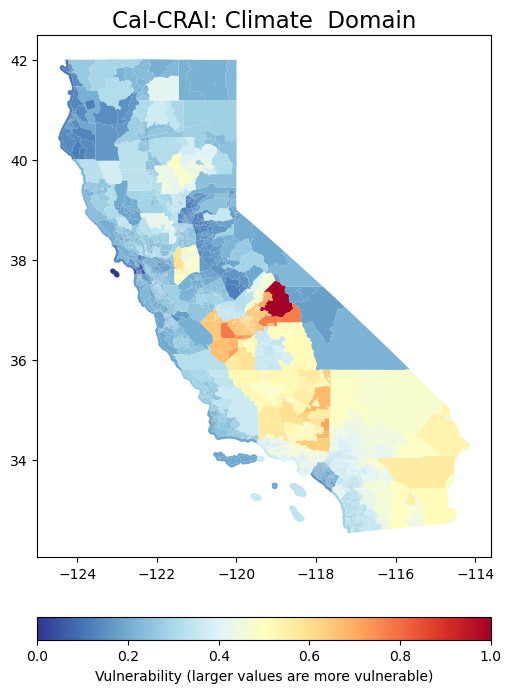

In [53]:
plot_domain(gdf, domain=domain_prefix)

### We can also visualize specific areas!
We call from a the `plot_region_domain` function which has a number of variables:

gdf : GeoDataFrame
    A GeoDataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.

counties_to_plot : list of str, optional
    A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
    Example: ['037', '071', '065', '029', '111'].

region : str, optional
    A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
    If specified, this will override `counties_to_plot`.

plot_all : bool, optional
    If True, plots all counties in California. Overrides `counties_to_plot` and `region`.

savefig : bool, optional
    If True, the plot will be saved as a PNG file. Default is False.

font_color : str, optional
    Color of the font for county labels. Default is 'black'.

domain_name : str, optional
    Name of the domain to include in the plot title. Default is 'Society and Economy Domain'.


    Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels
Below are a few example of each of these plotting scenarios

Number of invalid geometries: 0


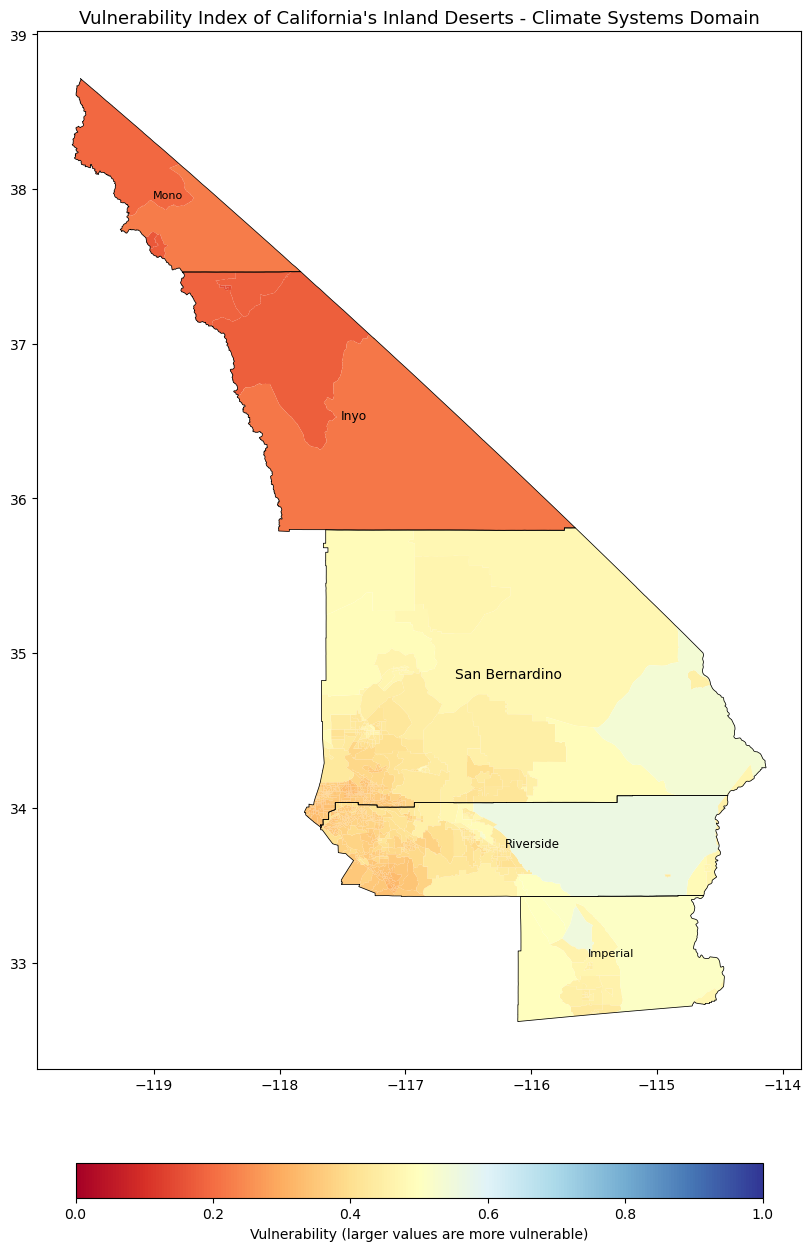

In [54]:
plot_region_domain(min_max_standardized_climate_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Climate Systems Domain'}, region='inland_deserts', savefig=False, font_color='black')

In [ ]:
min_max_standardized_climate_systems_domain

In [ ]:
plot_region_domain(min_max_standardized_climate_systems_domain, 
                   domain=domain_prefix, 
                   domain_label_map={domain_prefix: 'Climate Environment Domain'},
                   region='central_region',
                   savefig=False, 
                   font_color='black',
                   column_to_plot = 'all_domain_loss_exposure_product_min_max_standardized')

In [ ]:
list_of_counties = ['003']
plot_region_domain(min_max_standardized_climate_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Climate Environment Domain'}, counties_to_plot=list_of_counties, savefig=False, font_color='black')

In [ ]:
plot_region_domain(min_max_standardized_climate_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Climate Environment Domain'}, plot_all=True, savefig=False, font_color='black')

## Step 4: Export the final domain csv file

In [41]:
# set-up file for export
domain_filename = '{}domain_index_calculation.csv'.format(domain_prefix)
gdf.to_csv(domain_filename, index=False)

In [43]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files_upload = indicator_filename, domain_filename

for file in files_upload:
    upload_csv_aws([file], bucket_name, directory)

climate_domain_indicators.csv uploaded to AWS
climate_domain_index_calculation.csv uploaded to AWS
